In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [4]:
train_ds, val_ds, test_ds = load_dataset()

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель InceptionV3 без верхних слоев:

In [5]:
base_model = tf.keras.applications.Xception(input_shape=(256, 256, 3),
                                            include_top=False,
                                            weights='imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Заморозим слои, чтобы веса не обновлялись во время обучения:

In [7]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [8]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │        81,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,943,440 (79.89 MB)

 Trainable params: 81,960 (320.16 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Начнем обучение модели с замороженными нижними слоями:

In [10]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [11]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/xception.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [12]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


I0000 00:00:1713772973.798085  108267 service.cc:145] XLA service 0x7e99600041a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713772973.798119  108267 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-22 15:02:53.882230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 15:02:54.540027: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-22 15:03:00.164232: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead.

  1/433 ━━━━━━━━━━━━━━━━━━━━ 1:31:51 13s/step - accuracy: 0.0312 - loss: 3.8859

I0000 00:00:1713772983.052903  108267 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.1497 - loss: 3.3508

2024-04-22 15:04:19.557037: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


433/433 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - accuracy: 0.1500 - loss: 3.3500 - val_accuracy: 0.3997 - val_loss: 2.5519
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 73s 169ms/step - accuracy: 0.4332 - loss: 2.3929 - val_accuracy: 0.4909 - val_loss: 2.1042
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 71s 164ms/step - accuracy: 0.5129 - loss: 1.9961 - val_accuracy: 0.5287 - val_loss: 1.8771
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 71s 164ms/step - accuracy: 0.5526 - loss: 1.7790 - val_accuracy: 0.5425 - val_loss: 1.7417
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 72s 165ms/step - accuracy: 0.5793 - loss: 1.6369 - val_accuracy: 0.5679 - val_loss: 1.6355
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 72s 166ms/step - accuracy: 0.6006 - loss: 1.5323 - val_accuracy: 0.5790 - val_loss: 1.5651
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 72s 165ms/step - accuracy: 0.6169 - loss: 1.4549 - val_accuracy: 0.5918 - val_loss: 1.5024
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 71s 163ms/step - accuracy: 0.6292 - loss: 1.3940 - val

Так как число параметров в нижних слоях огромно (более 20 миллионов), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [13]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.6844 - loss: 1.1469


In [14]:
results

[1.1706253290176392, 0.680443525314331]

Посмотрим несколько предсказаний:

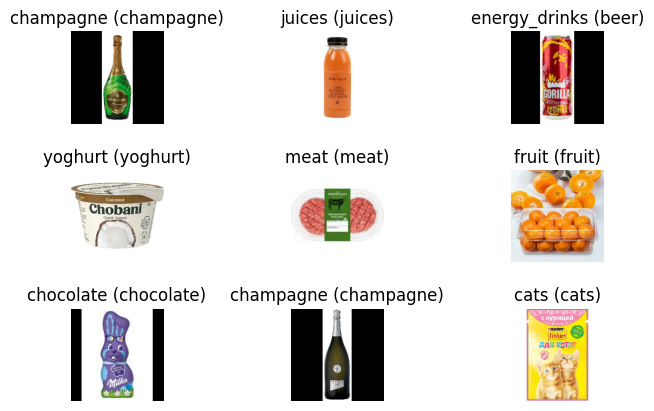

In [15]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


2024-04-22 16:11:48.181148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


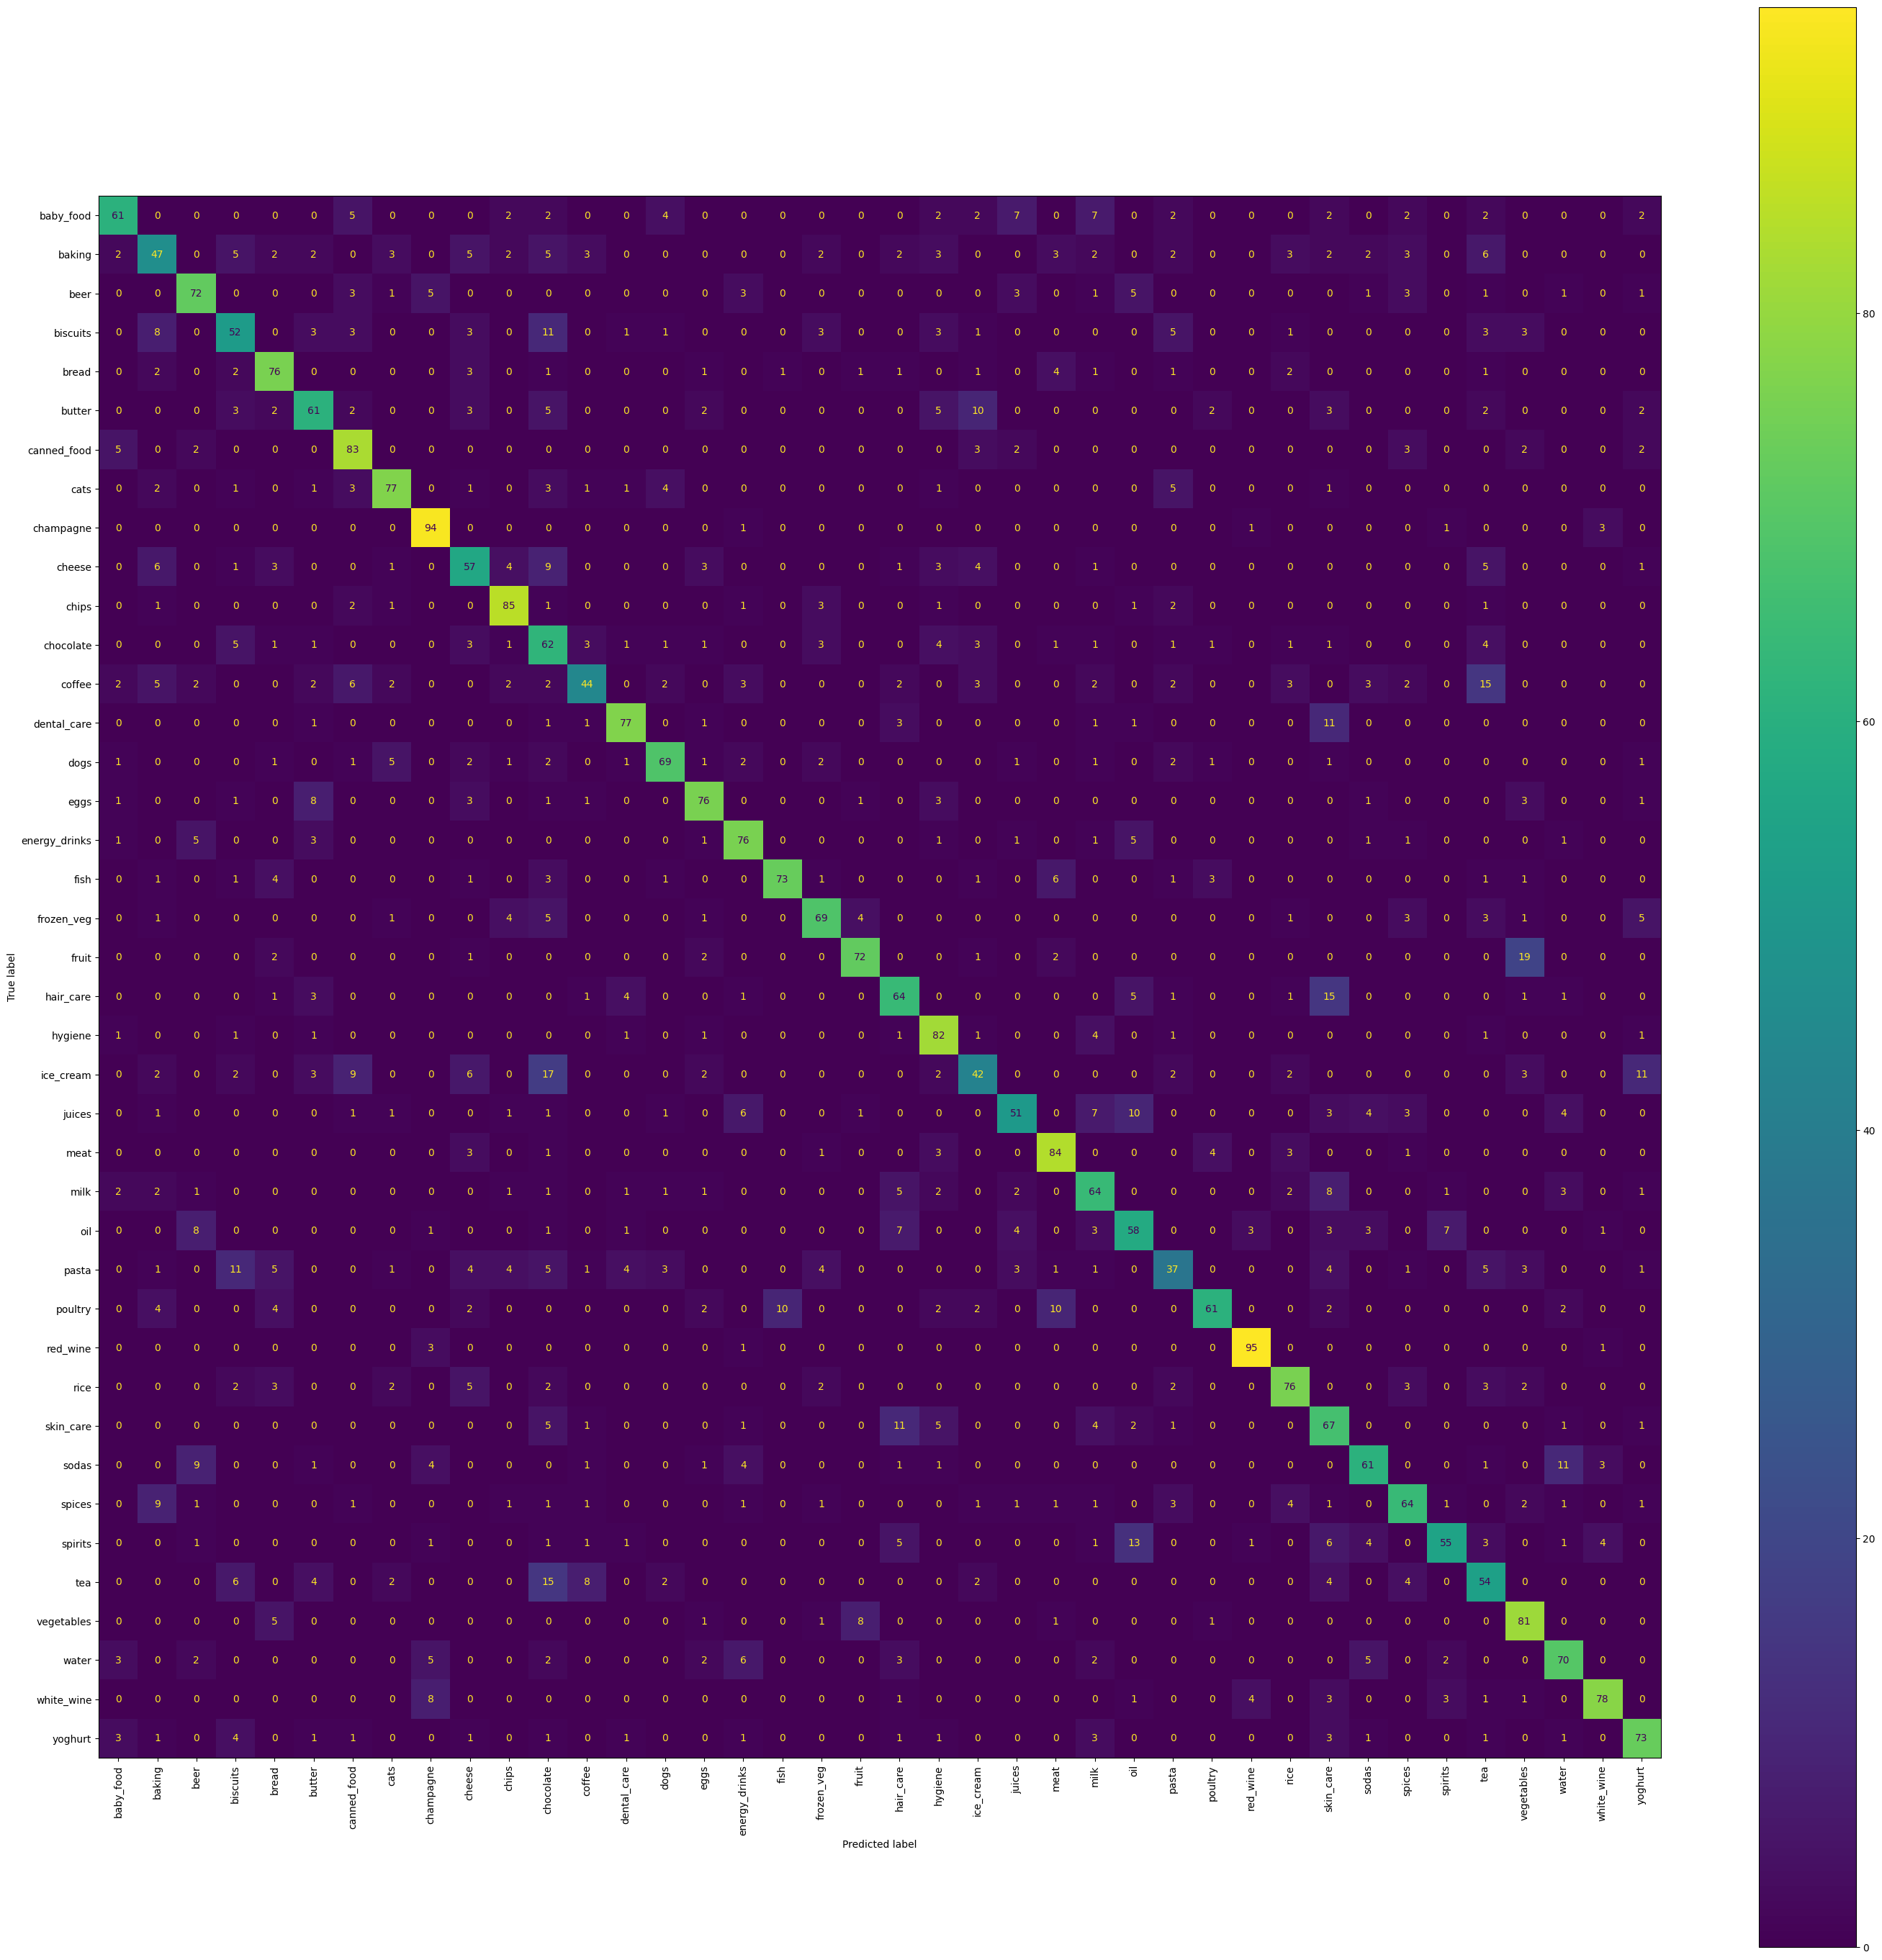

In [16]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [17]:
model.save('ready_models/xception.keras')

In [18]:
import json

with open('models_histories/xception.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

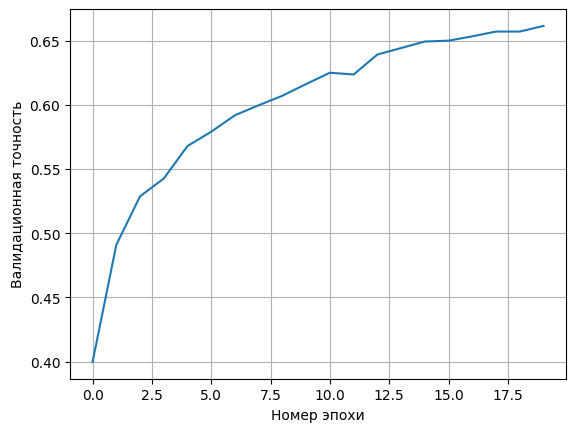

In [19]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')